# Basic Neural Networks 

(to compare pre-transfer learning)

In [1]:
# Standard imports
import os
import datetime
from pathlib import Path
from collections import defaultdict
import scipy
import random
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import pickle

# Machine learning libraries
import sklearn            # machine-learning libary with many algorithms implemented
#import xgboost as xgb     # extreme gradient boosting (XGB)
#from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential

# Python file with supporting functions
import model_utils

2023-01-09 19:28:02.114050: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
recon_model_path = '/home/julias/MLEE-final-project/models/saved_models/recon_models'

# Load Split Datasets and Create Versions for Experimentation

## Load Split Datasets

In [3]:
X_df = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/split_datasets/X.nc').to_dataframe().dropna()
y_df = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/split_datasets/y.nc').to_dataframe().dropna() 
X_train_df = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/split_datasets/X_train.nc').to_dataframe().dropna() 
y_train_df = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/split_datasets/y_train.nc').to_dataframe().dropna()
X_test_df = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/split_datasets/X_test.nc').to_dataframe().dropna() 
y_test_df = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/split_datasets/y_test.nc').to_dataframe().dropna() 

Check that data was saved and loaded properly:

In [4]:
X_train_df

SSS        SST         MLD       Chl  \
xlon   ylat  time                                                     
-179.5 -77.5 1996-12-15  34.519566  -1.687043  214.616638  2.408046   
             1997-01-15  34.359451   0.538524   18.861521  7.900837   
             1998-01-15  34.372940  -0.129260   48.051937  8.482795   
             2000-02-15  34.287220   2.750365   19.898767  0.205808   
             2003-01-15  34.288605  -0.362210   22.430550  8.158799   
...                            ...        ...         ...       ...   
 179.5  17.5 2007-11-15  34.276356  27.798658   48.323456  0.127090   
       -19.5 2012-04-15  34.280399  28.382263   26.312674  0.102510   
       -9.5  1990-09-15  34.241367  27.799450   66.605515  0.214787   
        58.5 1999-09-15  32.401649   9.241363   21.441675  0.457617   
        57.5 2011-08-15  32.590153   7.691035   18.062695  2.989490   

                               XCO2        T0        T1         A         B  \
xlon   ylat  time                                                             
-179.5 -77.5 1996-12-15  362.937073  0.966848 -0.255353 -0.976296 -0.001889   
             1997-01-15  363.078552  0.966848  0.255353 -0.976296 -0.001889   
             1998-01-15  365.225403  0.966848  0.255353 -0.976296 -0.001889   
             2000-02-15  368.928192  0.702527  0.711657 -0.976296 -0.001889   
             2003-01-15  374.658783  0.966848  0.255353 -0.976296 -0.001889   
...                             ...       ...       ...       ...       ...   
 179.5  17.5 2007-11-15  384.370575  0.702527 -0.711657  0.300706  0.008323   
       -19.5 2012-04-15  394.503143 -0.251190  0.967938 -0.333807  0.008226   
       -9.5  1990-09-15  354.576385 -0.267814 -0.963471 -0.165048  0.008607   
        58.5 1999-09-15  368.289978 -0.267814 -0.963471  0.852640  0.004560   
        57.5 2011-08-15  392.907837 -0.720667 -0.693281  0.843391  0.004689   

                                C  
xlon   ylat  time                  
-179.5 -77.5 1996-12-15  0.216431  
             1997-01-15  0.216431  
             1998-01-15  0.216431  
             2000-02-15  0.216431  
             2003-01-15  0.216431  
...                           ...  
 179.5  17.5 2007-11-15  0.953681  
       -19.5 2012-04-15  0.942606  
       -9.5  1990-09-15  0.986248  
        58.5 1999-09-15  0.522479  
        57.5 2011-08-15  0.537279  

[198577 rows x 10 columns]

In [5]:
y_test_df

pCO2
xlon   ylat  time                  
-179.5 -77.5 1997-02-15  166.861496
             2005-01-15  174.326938
             2005-11-15  313.570954
             2007-02-15  185.846402
             2015-01-15  173.178833
...                             ...
 179.5  28.5 1994-08-15  373.648703
       -19.5 2016-09-15  347.442384
       -61.5 2014-03-15  375.859202
       -44.5 2006-09-15  380.867286
       -40.5 1998-10-15  324.730352

[47610 rows x 1 columns]

### Create Numpy Arrays for Original Data

In [6]:
X_original = X_df.to_numpy()         
y_original = y_df.to_numpy().ravel() 
X_train_original = X_train_df.to_numpy() 
y_train_original = y_train_df.to_numpy().ravel()
X_test_original = X_test_df.to_numpy()  
y_test_original = y_test_df.to_numpy().ravel()

# Preliminary NN Model using Original (Not Normalized) Input

## Build NN Model

In [7]:
# NOTE that number of input layer neurons must correspond to number of predictor variables

In [8]:
# set hyperparameters
n_neuron       = 64
activation     = 'LeakyReLU'
num_epochs     = 50
learning_rate  = 0.001
minibatch_size = 64
model_num      = 1

In [9]:
y_train_df.shape[1]

1

In [10]:
NN_model = Sequential()

NN_model.add(Dense(n_neuron, name='hidden_layer_1', activation=activation,input_shape=(X_train_df.shape[1],))) #  the 1st hidden layer 
NN_model.add(Dense(n_neuron, name='hidden_layer_2', activation=activation)) # the 2nd hidden layer
NN_model.add(Dense(n_neuron, name='hidden_layer_3', activation=activation)) # the 3rd hidden layer
NN_model.add(Dense(1, name='output_layer', activation='linear')) # the output layer


NN_model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

2023-01-09 19:28:12.579766: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
NN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 64)                704       
                                                                 
 hidden_layer_2 (Dense)      (None, 64)                4160      
                                                                 
 hidden_layer_3 (Dense)      (None, 64)                4160      
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 9,089
Trainable params: 9,089
Non-trainable params: 0
_________________________________________________________________


In [12]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)


history = NN_model.fit(X_train_df, y_train_df, 
                            batch_size      = minibatch_size,
                            epochs          = num_epochs,
                            validation_split= 0.2, 
                            verbose         = 1,
                            callbacks       = [early_stop])

Epoch 1/50
2483/2483 [==============================] - 4s 1ms/step - loss: 1311.0815 - val_loss: 787.5729
Epoch 2/50
2483/2483 [==============================] - 3s 1ms/step - loss: 801.6011 - val_loss: 733.7604
Epoch 3/50
2483/2483 [==============================] - 3s 1ms/step - loss: 706.9982 - val_loss: 663.4531
Epoch 4/50
2483/2483 [==============================] - 3s 1ms/step - loss: 641.9575 - val_loss: 617.7894
Epoch 5/50
2483/2483 [==============================] - 3s 1ms/step - loss: 599.1472 - val_loss: 580.2218
Epoch 6/50
2483/2483 [==============================] - 3s 1ms/step - loss: 535.8091 - val_loss: 677.9593
Epoch 7/50
2483/2483 [==============================] - 3s 1ms/step - loss: 475.1862 - val_loss: 489.0060
Epoch 8/50
2483/2483 [==============================] - 3s 1ms/step - loss: 434.2048 - val_loss: 484.9232
Epoch 9/50
2483/2483 [==============================] - 3s 1ms/step - loss: 410.1913 - val_loss: 694.4598
Epoch 10/50
2483/2483 [======================

## Initial Checks

Can see that validation loss reaches minimums and jumps around, plot to see if trend indicates overfitting

Text(0.5, 1.0, 'Preliminary NN with Original Dataframe Input')

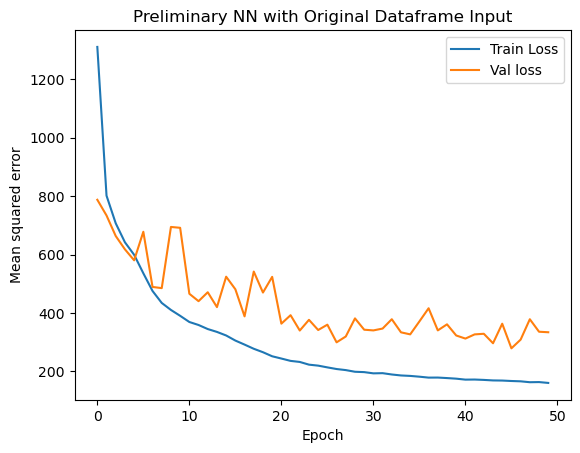

In [14]:
model_utils.plot_history(history)
plt.title('Preliminary NN with Original Dataframe Input')

- Indicates that the model isn't generalizing well
- While the training loss goes down substantially, the validation loss does not show the same trend. Instead, it remains (relatively) high and jumps around.
    - Completely fine, just signals that hyperparameter tuning will be needed (as expected)

In [ ]:
#Normalize so more comparable to other plot

In [ ]:
#history.history.keys()

In [ ]:
#norm_loss = (history.history['loss'] - np.mean(history.history['loss'])) / np.std(history.history['loss'])

In [ ]:
#norm_val_loss = (history.history['val_loss'] - np.mean(history.history['val_loss'])) / np.std(history.history['val_loss'])

In [ ]:
#x_ax = history.epoch
#plt.plot(x_ax, norm_loss, label="training")
#plt.plot(x_ax, norm_val_loss, label="validation")
#plt.title("Normalized Training and Validation Loss over Epochs")
#plt.legend()
#plt.show()

## Save NN Model

In [15]:
# after training, save:
NN_model.save(os.path.join(recon_model_path,'NN_model_prelim_originaldf2.h5'))

## Test NN Model

In [16]:
# then reload before start working with test data
NN_prelim_model = load_model(os.path.join(recon_model_path,'NN_model_prelim_originaldf2.h5'))

In [17]:
y_pred = NN_prelim_model.predict(X_test_df)
mse = mean_squared_error(y_test_df, y_pred)
print("MSE: %.2f" % mse)

1488/1488 [==============================] - 1s 666us/step
MSE: 233.60


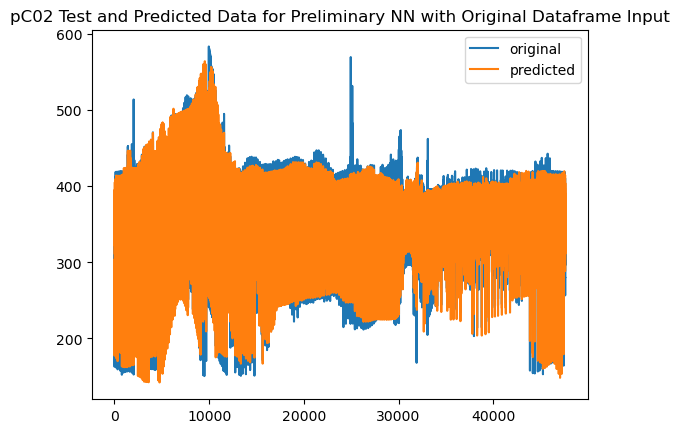

In [18]:
x_ax = range(len(y_test_df))
plt.plot(x_ax, y_test_df, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("pC02 Test and Predicted Data for Preliminary NN with Original Dataframe Input")
plt.legend()
plt.show()

# Preliminary NN Model using Original Numpy Input

## Build NN Model

In [19]:
# set hyperparameters
n_neuron       = 64
activation     = 'LeakyReLU'
num_epochs     = 50
learning_rate  = 0.001
minibatch_size = 64
model_num      = 1

In [20]:
X_train_original.shape[1]

10

In [21]:
NN_model_on = Sequential()

NN_model_on.add(Dense(n_neuron,  activation=activation,input_shape=(X_train_original.shape[1],))) #  the 1st hidden layer 
NN_model_on.add(Dense(n_neuron,  activation=activation)) # the 2nd hidden layer
NN_model_on.add(Dense(n_neuron,  activation=activation)) # the 3rd hidden layer
NN_model_on.add(Dense(1,  activation='linear')) # the output layer


NN_model_on.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

In [22]:
NN_model_on.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                704       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 9,089
Trainable params: 9,089
Non-trainable params: 0
_________________________________________________________________


## Train NN Model

In [23]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)


history_on = NN_model_on.fit(X_train_original, y_train_original, 
                            batch_size      = minibatch_size,
                            epochs          = num_epochs,
                            validation_split= 0.2, 
                            verbose         = 1,
                            callbacks       = [early_stop])

Epoch 1/50
2483/2483 [==============================] - 4s 1ms/step - loss: 1443.2778 - val_loss: 961.5924
Epoch 2/50
2483/2483 [==============================] - 3s 1ms/step - loss: 821.7379 - val_loss: 745.8525
Epoch 3/50
2483/2483 [==============================] - 3s 1ms/step - loss: 711.0809 - val_loss: 773.9365
Epoch 4/50
2483/2483 [==============================] - 3s 1ms/step - loss: 657.1293 - val_loss: 673.5639
Epoch 5/50
2483/2483 [==============================] - 3s 1ms/step - loss: 614.1435 - val_loss: 584.9130
Epoch 6/50
2483/2483 [==============================] - 3s 1ms/step - loss: 554.4302 - val_loss: 489.9801
Epoch 7/50
2483/2483 [==============================] - 3s 1ms/step - loss: 478.4497 - val_loss: 545.0214
Epoch 8/50
2483/2483 [==============================] - 3s 1ms/step - loss: 425.1944 - val_loss: 394.3022
Epoch 9/50
2483/2483 [==============================] - 3s 1ms/step - loss: 393.9578 - val_loss: 445.1561
Epoch 10/50
2483/2483 [======================

## Initial Checks

Text(0.5, 1.0, 'Preliminary NN with Original Numpy Input')

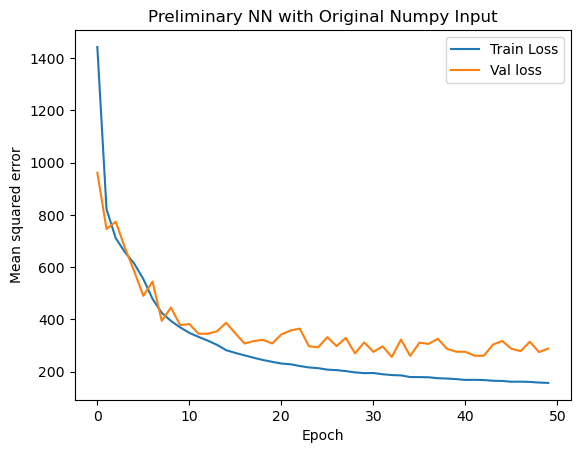

In [24]:
model_utils.plot_history(history_on)
plt.title('Preliminary NN with Original Numpy Input')

## Save NN Model

In [25]:
# after training, save:
NN_model_on.save(os.path.join(recon_model_path,'NN_model_prelim_originalnumpy2.h5'))

## Test NN Model

In [26]:
NN_model_on = load_model(os.path.join(recon_model_path,'NN_model_prelim_originalnumpy2.h5'))

In [27]:
y_pred_on = NN_model_on.predict(X_test_original)
mse = mean_squared_error(y_test_original, y_pred_on)
print("MSE: %.2f" % mse)

1488/1488 [==============================] - 1s 712us/step
MSE: 198.64


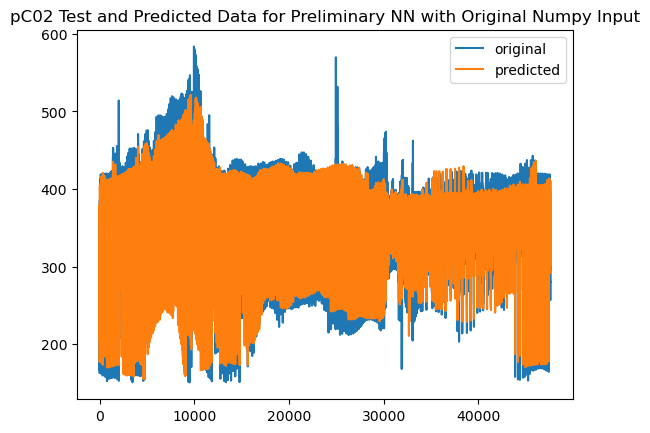

In [28]:
x_ax = range(len(y_test_original))
plt.plot(x_ax, y_test_original, label="original")
plt.plot(x_ax, y_pred_on, label="predicted")
plt.title("pC02 Test and Predicted Data for Preliminary NN with Original Numpy Input")
plt.legend()
plt.show()

# Create Normalized Dataframes

*Note: Done here, as opposed to in test/train split, so that I can save the original train/test datasets and later determine whether normalization led to improvement. (My group has not historically normalized data before training.)*

ALSO note, done after the above test on original dataframes because method overwrites original dataframes, need to debug this

In [29]:
#X_df_norm = (X_df - X_df.mean())/X_df.std() 
#y_df_norm = (y_df - y_df.mean())/y_df.std()
#X_train_df_norm = (X_train_df - X_train_df.mean())/X_train_df.std()
#y_train_df_norm = (y_train_df - y_train_df.mean())/y_train_df.std()
#X_test_df_norm = (X_test_df - X_test_df.mean())/X_test_df.std()
#y_test_df_norm = (y_test_df - y_test_df.mean())/y_test_df.std()

CHANGE METHOD TO BELOW
- This way, time and lat/lon conversions are not normalized
- Note that coordinates don't seem to be input into ML algorithms, so T0,T1,A,B,C are the inputs of time and space (as would want, don't want two forms of time and space input)

In [30]:
X_df_norm = X_df 
y_df_norm = y_df 
X_train_df_norm = X_train_df 
y_train_df_norm = y_train_df  
X_test_df_norm = X_test_df  
y_test_df_norm = y_test_df  

In [31]:
for df in X_df_norm, X_train_df_norm, X_test_df_norm:
    df.SSS = (df.SSS - df.SSS.mean())/df.SSS.std() 
    df.SST = (df.SST - df.SST.mean())/df.SST.std() 
    df.MLD = (df.MLD - df.MLD.mean())/df.MLD.std() 
    df.Chl = (df.Chl - df.Chl.mean())/df.Chl.std() 
    df.XCO2 = (df.XCO2 - df.XCO2.mean())/df.XCO2.std() 

for df in y_df_norm, y_train_df_norm, y_test_df_norm:
    df.pCO2 = (df.pCO2 - df.pCO2.mean())/df.pCO2.std() 

In [32]:
X_train_df_norm

SSS       SST       MLD       Chl      XCO2  \
xlon   ylat  time                                                           
-179.5 -77.5 1996-12-15 -0.012027 -2.158344  1.757647  2.447165 -1.290389   
             1997-01-15 -0.125725 -1.912520 -0.609001  9.033164 -1.281295   
             1998-01-15 -0.116146 -1.986280 -0.256093  9.730947 -1.143301   
             2000-02-15 -0.177016 -1.668212 -0.596461 -0.193376 -0.905294   
             2003-01-15 -0.176033 -2.012010 -0.565852  9.342467 -0.536946   
...                           ...       ...       ...       ...       ...   
 179.5  17.5 2007-11-15 -0.184731  1.098486 -0.252811 -0.287760  0.087305   
       -19.5 2012-04-15 -0.181860  1.162948 -0.518918 -0.317233  0.738602   
       -9.5  1990-09-15 -0.209576  1.098573 -0.031784 -0.182610 -1.827794   
        58.5 1999-09-15 -1.515965 -0.951252 -0.577807  0.108549 -0.946317   
        57.5 2011-08-15 -1.382108 -1.122492 -0.618659  3.144331  0.636059   

                               T0        T1         A         B         C  
xlon   ylat  time                                                          
-179.5 -77.5 1996-12-15  0.966848 -0.255353 -0.976296 -0.001889  0.216431  
             1997-01-15  0.966848  0.255353 -0.976296 -0.001889  0.216431  
             1998-01-15  0.966848  0.255353 -0.976296 -0.001889  0.216431  
             2000-02-15  0.702527  0.711657 -0.976296 -0.001889  0.216431  
             2003-01-15  0.966848  0.255353 -0.976296 -0.001889  0.216431  
...                           ...       ...       ...       ...       ...  
 179.5  17.5 2007-11-15  0.702527 -0.711657  0.300706  0.008323  0.953681  
       -19.5 2012-04-15 -0.251190  0.967938 -0.333807  0.008226  0.942606  
       -9.5  1990-09-15 -0.267814 -0.963471 -0.165048  0.008607  0.986248  
        58.5 1999-09-15 -0.267814 -0.963471  0.852640  0.004560  0.522479  
        57.5 2011-08-15 -0.720667 -0.693281  0.843391  0.004689  0.537279  

[198577 rows x 10 columns]

In [33]:
X_train_df

SSS       SST       MLD       Chl      XCO2  \
xlon   ylat  time                                                           
-179.5 -77.5 1996-12-15 -0.012027 -2.158344  1.757647  2.447165 -1.290389   
             1997-01-15 -0.125725 -1.912520 -0.609001  9.033164 -1.281295   
             1998-01-15 -0.116146 -1.986280 -0.256093  9.730947 -1.143301   
             2000-02-15 -0.177016 -1.668212 -0.596461 -0.193376 -0.905294   
             2003-01-15 -0.176033 -2.012010 -0.565852  9.342467 -0.536946   
...                           ...       ...       ...       ...       ...   
 179.5  17.5 2007-11-15 -0.184731  1.098486 -0.252811 -0.287760  0.087305   
       -19.5 2012-04-15 -0.181860  1.162948 -0.518918 -0.317233  0.738602   
       -9.5  1990-09-15 -0.209576  1.098573 -0.031784 -0.182610 -1.827794   
        58.5 1999-09-15 -1.515965 -0.951252 -0.577807  0.108549 -0.946317   
        57.5 2011-08-15 -1.382108 -1.122492 -0.618659  3.144331  0.636059   

                               T0        T1         A         B         C  
xlon   ylat  time                                                          
-179.5 -77.5 1996-12-15  0.966848 -0.255353 -0.976296 -0.001889  0.216431  
             1997-01-15  0.966848  0.255353 -0.976296 -0.001889  0.216431  
             1998-01-15  0.966848  0.255353 -0.976296 -0.001889  0.216431  
             2000-02-15  0.702527  0.711657 -0.976296 -0.001889  0.216431  
             2003-01-15  0.966848  0.255353 -0.976296 -0.001889  0.216431  
...                           ...       ...       ...       ...       ...  
 179.5  17.5 2007-11-15  0.702527 -0.711657  0.300706  0.008323  0.953681  
       -19.5 2012-04-15 -0.251190  0.967938 -0.333807  0.008226  0.942606  
       -9.5  1990-09-15 -0.267814 -0.963471 -0.165048  0.008607  0.986248  
        58.5 1999-09-15 -0.267814 -0.963471  0.852640  0.004560  0.522479  
        57.5 2011-08-15 -0.720667 -0.693281  0.843391  0.004689  0.537279  

[198577 rows x 10 columns]

Recreate original dataframes, as they are getting overwritten by the above process 

In [56]:
X_df = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/split_datasets/X.nc').to_dataframe().dropna()
y_df = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/split_datasets/y.nc').to_dataframe().dropna() 
X_train_df = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/split_datasets/X_train.nc').to_dataframe().dropna() 
y_train_df = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/split_datasets/y_train.nc').to_dataframe().dropna()
X_test_df = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/split_datasets/X_test.nc').to_dataframe().dropna() 
y_test_df = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/split_datasets/y_test.nc').to_dataframe().dropna() 

## Create Numpy Arrays 

In [34]:
X_n = X_df_norm.to_numpy()         
y_n = y_df_norm.to_numpy().ravel() 
X_train_n = X_train_df_norm.to_numpy()
y_train_n = y_train_df_norm.to_numpy().ravel()
X_test_n = X_test_df_norm.to_numpy() 
y_test_n = y_test_df_norm.to_numpy().ravel()

In [35]:
X_n.shape

(246187, 10)

# Preliminary NN Model using Normalized Input

## Build NN Model

In [36]:
# set hyperparameters
n_neuron       = 64
activation     = 'LeakyReLU'
num_epochs     = 50
learning_rate  = 0.001
minibatch_size = 64
model_num      = 1

In [37]:
X_train_df_norm.shape[1]

10

In [38]:
NN_model_nprelim = Sequential()

NN_model_nprelim.add(Dense(n_neuron,  activation=activation,input_shape=(X_train_df_norm.shape[1],))) #  the 1st hidden layer 
NN_model_nprelim.add(Dense(n_neuron,  activation=activation)) # the 2nd hidden layer
NN_model_nprelim.add(Dense(n_neuron,  activation=activation)) # the 3rd hidden layer
NN_model_nprelim.add(Dense(1,  activation='linear')) # the output layer


NN_model_nprelim.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

In [39]:
NN_model_nprelim.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 64)                704       
                                                                 
 dense_5 (Dense)             (None, 64)                4160      
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 9,089
Trainable params: 9,089
Non-trainable params: 0
_________________________________________________________________


## Train NN Model

In [40]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)


history_nprelim = NN_model_nprelim.fit(X_train_df_norm, y_train_df_norm, 
                            batch_size      = minibatch_size,
                            epochs          = num_epochs,
                            validation_split= 0.2, 
                            verbose         = 1,
                            callbacks       = [early_stop])

Epoch 1/50
2483/2483 [==============================] - 4s 1ms/step - loss: 0.2155 - val_loss: 0.2054
Epoch 2/50
2483/2483 [==============================] - 3s 1ms/step - loss: 0.1231 - val_loss: 0.1674
Epoch 3/50
2483/2483 [==============================] - 3s 1ms/step - loss: 0.1053 - val_loss: 0.1585
Epoch 4/50
2483/2483 [==============================] - 3s 1ms/step - loss: 0.0972 - val_loss: 0.1352
Epoch 5/50
2483/2483 [==============================] - 3s 1ms/step - loss: 0.0911 - val_loss: 0.1451
Epoch 6/50
2483/2483 [==============================] - 3s 1ms/step - loss: 0.0867 - val_loss: 0.1470
Epoch 7/50
2483/2483 [==============================] - 3s 1ms/step - loss: 0.0834 - val_loss: 0.1342
Epoch 8/50
2483/2483 [==============================] - 3s 1ms/step - loss: 0.0802 - val_loss: 0.1288
Epoch 9/50
2483/2483 [==============================] - 3s 1ms/step - loss: 0.0780 - val_loss: 0.1314
Epoch 10/50
2483/2483 [==============================] - 3s 1ms/step - loss: 0.075

## Initial Checks

Text(0.5, 1.0, 'Preliminary NN with Normalized Dataframe Input')

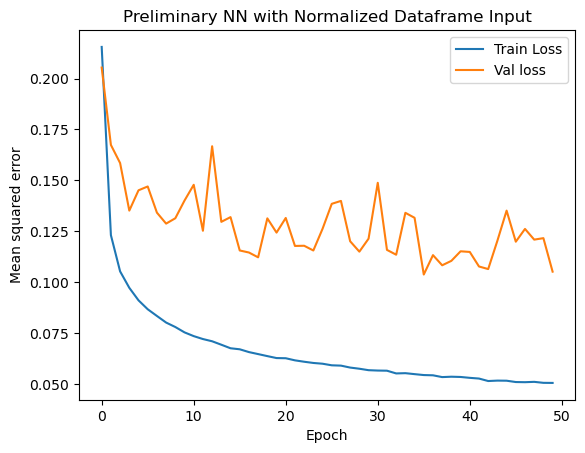

In [41]:
model_utils.plot_history(history_nprelim)
plt.title('Preliminary NN with Normalized Dataframe Input')

## Save NN Model

In [42]:
# after training, save:
NN_model_nprelim.save(os.path.join(recon_model_path,'NN_model_prelim_normdf2.h5'))

## Test NN Model

In [43]:
NN_model_nprelim = load_model(os.path.join(recon_model_path,'NN_model_prelim_normdf2.h5'))

In [44]:
y_pred_nprelim = NN_model_nprelim.predict(X_test_df_norm)
mse = mean_squared_error(y_test_df_norm, y_pred_nprelim)
print("MSE: %.2f" % mse)

1488/1488 [==============================] - 1s 626us/step
MSE: 0.09


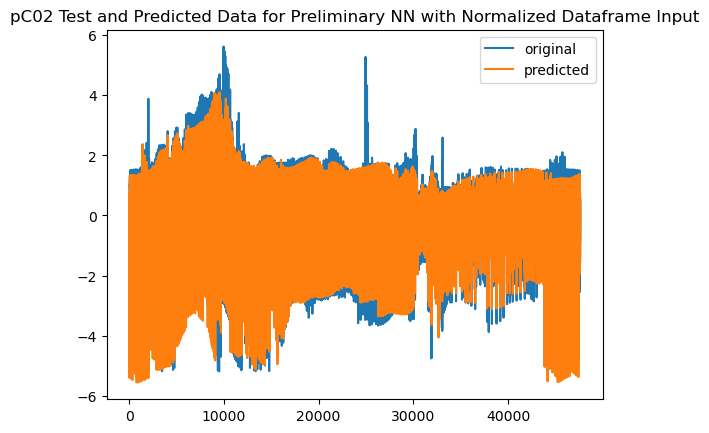

In [45]:
x_ax = range(len(y_test_df_norm))
plt.plot(x_ax, y_test_df_norm, label="original")
plt.plot(x_ax, y_pred_nprelim, label="predicted")
plt.title("pC02 Test and Predicted Data for Preliminary NN with Normalized Dataframe Input")
plt.legend()
plt.show()

# Preliminary NN Model using Normalized Numpy Input

## Build NN Model

In [46]:
# set hyperparameters
n_neuron       = 64
activation     = 'LeakyReLU'
num_epochs     = 50
learning_rate  = 0.001
minibatch_size = 64
model_num      = 1

In [47]:
X_train_n.shape[1]

10

In [48]:
NN_model_nn = Sequential()

NN_model_nn.add(Dense(n_neuron,  activation=activation,input_shape=(X_train_n.shape[1],))) #  the 1st hidden layer 
NN_model_nn.add(Dense(n_neuron,  activation=activation)) # the 2nd hidden layer
NN_model_nn.add(Dense(n_neuron,  activation=activation)) # the 3rd hidden layer
NN_model_nn.add(Dense(1,  activation='linear')) # the output layer


NN_model_nn.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

In [49]:
NN_model_nn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 64)                704       
                                                                 
 dense_9 (Dense)             (None, 64)                4160      
                                                                 
 dense_10 (Dense)            (None, 64)                4160      
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 9,089
Trainable params: 9,089
Non-trainable params: 0
_________________________________________________________________


## Train NN Model

In [50]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)


history_nn = NN_model_nn.fit(X_train_n, y_train_n, 
                            batch_size      = minibatch_size,
                            epochs          = num_epochs,
                            validation_split= 0.2, 
                            verbose         = 1,
                            callbacks       = [early_stop])

Epoch 1/50
2483/2483 [==============================] - 4s 1ms/step - loss: 0.2157 - val_loss: 0.1994
Epoch 2/50
2483/2483 [==============================] - 3s 1ms/step - loss: 0.1255 - val_loss: 0.1640
Epoch 3/50
2483/2483 [==============================] - 3s 1ms/step - loss: 0.1076 - val_loss: 0.1779
Epoch 4/50
2483/2483 [==============================] - 3s 1ms/step - loss: 0.0986 - val_loss: 0.1565
Epoch 5/50
2483/2483 [==============================] - 3s 1ms/step - loss: 0.0932 - val_loss: 0.1542
Epoch 6/50
2483/2483 [==============================] - 3s 1ms/step - loss: 0.0873 - val_loss: 0.1536
Epoch 7/50
2483/2483 [==============================] - 3s 1ms/step - loss: 0.0833 - val_loss: 0.1337
Epoch 8/50
2483/2483 [==============================] - 3s 1ms/step - loss: 0.0809 - val_loss: 0.1836
Epoch 9/50
2483/2483 [==============================] - 3s 1ms/step - loss: 0.0784 - val_loss: 0.1610
Epoch 10/50
2483/2483 [==============================] - 3s 1ms/step - loss: 0.075

## Initial Checks

Text(0.5, 1.0, 'Preliminary NN with Normalized Numpy Input')

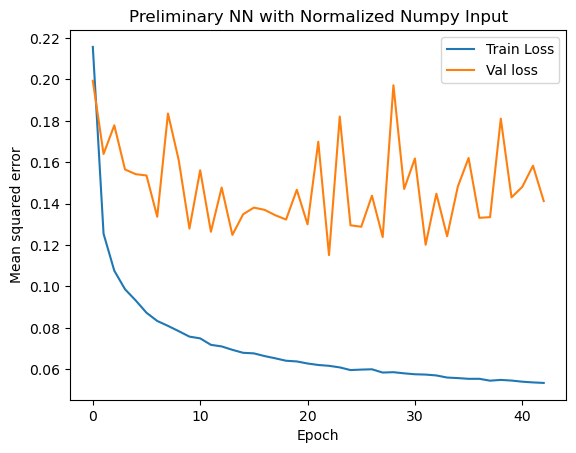

In [51]:
model_utils.plot_history(history_nn)
plt.title('Preliminary NN with Normalized Numpy Input')

## Save NN Model

In [52]:
# after training, save:
NN_model_nn.save(os.path.join(recon_model_path,'NN_model_prelim_normnumpy2.h5'))

## Test NN Model

In [53]:
NN_model_nn = load_model(os.path.join(recon_model_path,'NN_model_prelim_normnumpy2.h5'))

In [54]:
y_pred_nn = NN_model_nn.predict(X_test_n)
mse = mean_squared_error(y_test_n, y_pred_nn)
print("MSE: %.2f" % mse)

1488/1488 [==============================] - 1s 791us/step
MSE: 0.09


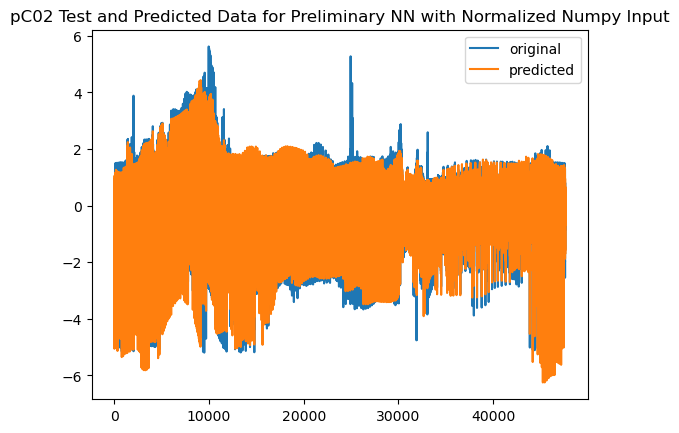

In [55]:
x_ax = range(len(y_test_n))
plt.plot(x_ax, y_test_n, label="original")
plt.plot(x_ax, y_pred_nn, label="predicted")
plt.title("pC02 Test and Predicted Data for Preliminary NN with Normalized Numpy Input")
plt.legend()
plt.show()

# Select Approach & Parameters

## Approach

- Based on preliminary experimentation, will train the NN model on original dataframes
- Comparison completed above for group reference, as data has not historically been normalized prior to training
- Regarding normalization
    - Likely need to debug or investigate normalizing specific input parameters
    - For both the dataframe and numpy normalized inputs, validation losses did not decrease with training losses. This could mean overfitting to the training set; maybe normalization makes it "too easy" for the algorithm to learn the training set.
- Regarding dataframe vs numpy array
    - The difference between dataframe and numpy input is likely not significant, as runs for original and normalized data were similar. 
    - NN based on original dataframe input had a slightly higher MSE than that based on the numpy input, but the difference likely was not significant/could be due to random variation in runs. 
    - Visually, use of the original dataframe resulted in more closely aligned predicted pCO2, particularly at the extremes. 

## Parameters

Experimentation with hyperparameters completed below

### Experiment with NN Model

In [82]:
# First Run
#n_neuron       = 100
#activation     = 'LeakyReLU'
#num_epochs     = 100
#learning_rate  = 0.002
#minibatch_size = 64
#model_num      = 1
#early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

# loss: 124.3420 - val_loss: 289.1165
# MSE: 181.18
# stopped after 91 epochs 

In [83]:
# Second Run
#n_neuron       = 64
#activation     = 'LeakyReLU'
#num_epochs     = 100
#learning_rate  = 0.0015
#minibatch_size = 64
#model_num      = 1
#early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
#NN_model_exp.add(Dense(n_neuron, activation=activation, name='hidden_layer_4')) # added a 4th layer

# loss: mid 100s - val_loss: mid 300s
# MSE: 228.09
# stopped after 49 epochs 

In [89]:
# Third Run
#n_neuron       = 64
#activation     = 'LeakyReLU'
#num_epochs     = 100
#learning_rate  = 0.0005
#minibatch_size = 64
#model_num      = 1
#early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
#NN_model_exp.add(Dense(n_neuron, activation=activation, name='hidden_layer_4')) # added a 4th layer

#loss: 193.3637 - val_loss: 375.5946
# MSE:
# stopped after 40 epochs, but at start was much more aligned

In [104]:
# 4th and 5th runs
#n_neuron       = 64
#activation     = 'ReLU'
#num_epochs     = 100
#learning_rate  = 0.0005
#minibatch_size = 64
#model_num      = 1
# and made only two hidden layers 
#early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

# MSE: 289.26, loss: 257.6627 - val_loss: 366.7357 but trend MUCH more aligned, up patience from 10 to 20, and try Relu

# MSE: 267.70, loss: 225.0135 - val_loss: 318.7133, trend aligned even more, through almost all epochs

In [116]:
# 6th run
#n_neuron       = 100
#activation     = 'ReLU'
#num_epochs     = 100
#learning_rate  = 0.0008
#minibatch_size = 64
#model_num      = 1
# and made only two hidden layers 
#early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

# ran for 74 epochs
# MSE: 255.24, loss: 180.7052 - val_loss: 294.3801 
# train/val trend not quite as aligned as previous run
# go back to first run and start again from there
# common between first run and this one: higher number of neurons, up again

In [122]:
# 7th Run and 8th Run
#n_neuron       = 150
#activation     = 'ReLU'
#num_epochs     = 100
#learning_rate  = 0.002
#minibatch_size = 64
#model_num      = 1
#early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

# loss: 178.2955 - val_loss: 316.7465
# definitely not, trend not great again --> try with Relu instead of Leaky 
# MSE: 219.80, 162.3405 - val_loss: 343.4025

In [134]:
# 9th Run
#n_neuron       = 100
#activation     = 'ReLU'
#num_epochs     = 100
#learning_rate  = 0.002
#minibatch_size = 64
#model_num      = 1
#early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

# MSE: 208.60, loss: 170.7158 - val_loss: 282.2546
# good train/val loss alignment but stopped at 64 epochs

In [135]:
# 10th Run
#n_neuron       = 100
#activation     = 'ReLU'
#num_epochs     = 100
#learning_rate  = 0.0005
#minibatch_size = 100
#model_num      = 1
#early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

#loss: 186.7061 - val_loss: 267.3068, MSE: 238.85
# but, best alignment between train and val loss so far
# take best run so far and increase batch size

Take best trends of all runs
- Relu over LeakyRelu
- Increase mini batch size to 100
- Don't alter neurons (worse when increase and decrease)
- Maintain learning rate, but maybe could go down, 0.0005 did well

In [165]:
# 11th and 12th Run and 13th run **12th is saved, 13th just swapped back to Leaky Relu **was worse, back to run 12
n_neuron       = 100
activation     = 'ReLU'
num_epochs     = 100
learning_rate  = 0.0005 # 0.002 definitely overtrained, val didn't decrease after approx 20 epochs, loss: 144.7867 - val_loss: 389.3859, MSE 208
minibatch_size = 100
model_num      = 1
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

# loss: 143.5514 - val_loss: 239.9906
# MSE: 192.47
# ran all 100 epochs, and really consistent train val losses

In [161]:
NN_model_exp = Sequential()

NN_model_exp.add(Dense(n_neuron, activation=activation, name='hidden_layer_1', input_shape=(X_train_df.shape[1],))) #  the 1st hidden layer 
NN_model_exp.add(Dense(n_neuron, activation=activation, name='hidden_layer_2')) # the 2nd hidden layer
NN_model_exp.add(Dense(n_neuron, activation=activation, name='hidden_layer_3')) 
NN_model_exp.add(Dense(1, activation='linear', name='output_layer')) # the output layer


NN_model_exp.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

In [162]:
NN_model_exp.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 100)               1100      
                                                                 
 hidden_layer_2 (Dense)      (None, 100)               10100     
                                                                 
 hidden_layer_3 (Dense)      (None, 100)               10100     
                                                                 
 output_layer (Dense)        (None, 1)                 101       
                                                                 
Total params: 21,401
Trainable params: 21,401
Non-trainable params: 0
_________________________________________________________________


### Train Experimental NN Model

In [163]:
history_exp = NN_model_exp.fit(X_train_df, y_train_df, 
                            batch_size      = minibatch_size,
                            epochs          = num_epochs,
                            validation_split= 0.2, 
                            verbose         = 1,
                            callbacks       = [early_stop])

Epoch 1/100
1589/1589 [==============================] - 3s 2ms/step - loss: 1713.5983 - val_loss: 814.4709
Epoch 2/100
1589/1589 [==============================] - 3s 2ms/step - loss: 823.6177 - val_loss: 744.4655
Epoch 3/100
1589/1589 [==============================] - 3s 2ms/step - loss: 778.5672 - val_loss: 841.4984
Epoch 4/100
1589/1589 [==============================] - 3s 2ms/step - loss: 735.3333 - val_loss: 747.4641
Epoch 5/100
1589/1589 [==============================] - 3s 2ms/step - loss: 692.1860 - val_loss: 697.7972
Epoch 6/100
1589/1589 [==============================] - 3s 2ms/step - loss: 644.5073 - val_loss: 705.2658
Epoch 7/100
1589/1589 [==============================] - 3s 2ms/step - loss: 610.8588 - val_loss: 606.7575
Epoch 8/100
1589/1589 [==============================] - 3s 2ms/step - loss: 588.6667 - val_loss: 579.7200
Epoch 9/100
1589/1589 [==============================] - 3s 2ms/step - loss: 562.7102 - val_loss: 546.5051
Epoch 10/100
1589/1589 [============

### Initial Checks on Experimental NN Model

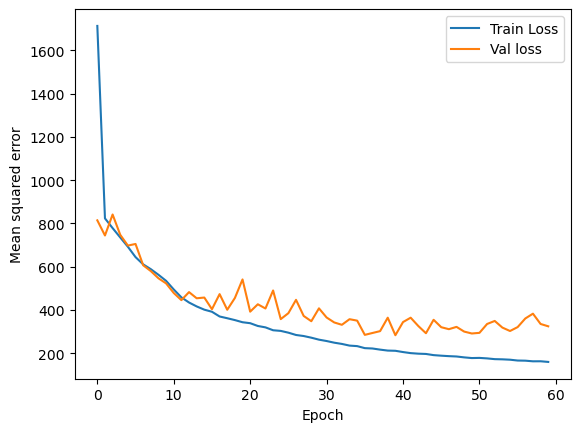

In [164]:
model_utils.plot_history(history_exp)

In [156]:
y_pred_exp = NN_model_exp.predict(X_test_df)
mse = mean_squared_error(y_test_df, y_pred_exp)
print("MSE: %.2f" % mse)

1488/1488 [==============================] - 1s 814us/step
MSE: 192.47


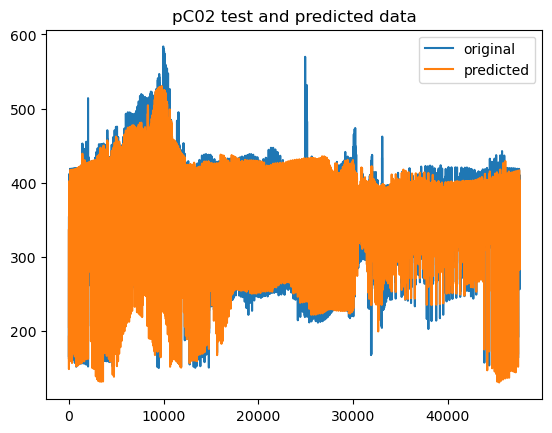

In [158]:
x_ax = range(len(y_test_df))
plt.plot(x_ax, y_test_df, label="original")
plt.plot(x_ax, y_pred_exp, label="predicted")
plt.title("pC02 test and predicted data")
plt.legend()
plt.show()

### Save Best Experimental NN Model as First of NN Below

In [159]:
# after training, save:
NN_model_exp.save(os.path.join(recon_model_path,'NN_model1.h5'))

# Five Identical NN Models 

## NN Model 1

In [ ]:
NN_model1 = load_model(os.path.join(recon_model_path,'NN_model1.h5'))

## NN Model 2

## NN Model 3

## NN Model 4

## NN Model 5